In [1]:
import os
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import OrderedDict

import matplotlib.pyplot as plt

from openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [8]:
class DataPlotter(object):
    
    def __init__(self, d_labels_to_info):
        """
        Parameters
        ----------
        d_labels_to_info : OrderedDict()
            contains free energy data for each experiment
            key : name of experiment (format: '{single letter amino acid of WT}{residue id}{single letter amino acid of mutant} 
                                                {phase} ({simulation type} r{replicate number})')
            value : dict with the following keys:
                key : list of file path(s) to free energy data
                key : list of starting indices to use in slicing the free energy data
                key : list of ending indices to use in slicing the free energy data
                key : total iterations to analyze 
            
            example: 
            d_labels_to_info = OrderedDict({
                "A42T complex (AREX r1)": {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [50],
                                               "total_iterations": 50000,
                                              }
                })
        """
        
        # Set unsampled state indices
        self.first_unsampled_state_index = 0
        self.last_unsampled_state_index = -1
        
        # Load complex free energy data
        data = OrderedDict()
        for i, (label, d_info) in enumerate(d_labels_to_info.items()):
            
            if "apo" not in label:
                
                # Load complex free energy matrices at each time point
                file_paths = d_info["file_paths"]
                slice_begs = d_info["slice_begs"]
                slice_ends = d_info["slice_ends"]
                total_iterations = d_info["total_iterations"]

                for j, (file_path, slice_beg, slice_end) in enumerate(zip(file_paths, slice_begs, slice_ends)):

                    if j == 0:
                        with open(file_path, "rb") as f:
                            results = pickle.load(f)
                        data[label] = {"results": results[slice_beg:slice_end]}

                    else:
                        with open(file_path, "rb") as f:
                            results = pickle.load(f)
                        data[label]["results"] += results[slice_beg:slice_end]

                data[label]["total_iterations"] = total_iterations
            
            else:
                
                # Load apo free energy data (10 ns/replica AREX)
                file_path_apo = d_info["file_paths"][0]
                with open(file_path_apo, "rb") as f:
                    results = pickle.load(f)
                data[label] = {"results": results}
        
        # Experiment
        experiment = {"Y29F": -0.1, 
                      "Y29A": 3.4, 
                      "W38F": 1.6, 
                      "T42A": 1.8, 
                      "W44F": 0.0, 
                      "E76A": 1.4, 
                      "E80A": 0.5, 
                      "D35A": 4.5, 
                      "D39A": 7.7, 
                      "K27A": 5.4, 
                      "R59A": 5.2, 
                      "R83Q": 5.4, 
                      "R87A": 5.5, 
                      "H102A": 6.1, 
                      "F29Y": 0.1, 
                      "A29Y": -3.4, 
                      "F38W": -1.6, 
                      "A42T": -1.8, 
                      "F44W": 0.0, 
                      "A76E": -1.4, 
                      "A80E": -0.5, 
                      "A35D": -4.5, 
                      "A39D": -7.7, 
                      "A27K": -5.4, 
                      "A59R": -5.2, 
                      "Q83R": -5.4, 
                      "A87R": -5.5, 
                      "A102H": -6.1}
        data["experiment"] = experiment
        
        self.data = data
        
        # Set colors
        self.colors = ["#80b1d3", "#fdb462", "#b3de69"]
        
    def _generate_free_energy_rmse_mue_timeseries_plot(self, 
                                              show_legend=False, 
                                              y_axis_min=None, 
                                              y_axis_max=None, 
                                              legend_ncol=2,
                                              figsize=None,
                                              save_path=None):
        """
        Generate RMSE and MUE timeseries plots 
        
        Parameters
        ----------
        show_legend : boolean, default False
            whether to show the legend
        y_axis_min : float, default None
            minimum value for the y axis
        y_axis_max : float, default None
            maximum value for the y axis
        legend_ncol : int, default 2
            number of columns in the legend
        figsize : tuple of ints, default None
            dimensions to use for generating the figure
        save_path : str
            filepath at which to save the figure
        """
        
        # Assemble data
        dgs_complex_arex = {} # key : mutation name, value: complex AREX free energy timeseries
        dgs_complex_arest = {} # key : mutation name, value: complex AREST free energy timeseries
        dgs_apo = {} # key : mutation name, value: apo AREX free energy at 10 ns
        labels = [] # label for each simulation type
        for i, (label, data) in enumerate(self.data.items()):
            
            if "apo" not in label and "experiment" not in label: 
                
                # Get total ns
                total_ns = int(data["total_iterations"] / 1000)
                
                # Retrieve label
                title = label.split("(")[0][:-1]
                mutation = title.split(" ")[0]
                experiment_label = label.split("(")[-1][:-1]
                simulation_type = experiment_label[:-3]
                is_arest = True if "AREST" in simulation_type else False
                if simulation_type not in labels:
                    labels.append(simulation_type)

                # Retrieve x values (time points)
                x = np.array(range(1000, data["total_iterations"] + 1, 1000)) / 1000

                # Retrieve complex free energies in kcal/mol
                dgs = np.array([t["Deltaf"][self.first_unsampled_state_index, self.last_unsampled_state_index] * KT_KCALMOL for t in data["results"]])

                # Store the complex free energy timeseries 
                if is_arest:
                    dgs_complex_arest[mutation] = dgs
                else:
                    dgs_complex_arex[mutation] = dgs
                
            elif "apo" in label:
                
                 # Retrieve label
                title = label.split("(")[0][:-1]
                mutation = title.split(" ")[0]
                experiment_label = label.split("(")[-1][:-1]
                simulation_type = experiment_label[:-3]
                if simulation_type not in labels:
                    labels.append(simulation_type)

                # Assemble apo free energies
                dg = data["results"]["Deltaf"][self.first_unsampled_state_index, self.last_unsampled_state_index] * KT_KCALMOL
                ddg = data["results"]["dDeltaf"][self.first_unsampled_state_index, self.last_unsampled_state_index] * KT_KCALMOL

                # Store the apo free energy timeseries 
                dgs_apo[mutation] = dg
                
        # Set font size
        plt.rc('font', size=20) 
        
        for statistic_name in ["RMSE", "MUE"]:
            
            # Set default for y_axis_mean
            y_axis_mean = -1e6

            # Set figure size
            if not figsize:
                figsize = (8, 4)
            fig, axes = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=figsize)
            
            for label_index, dgs_complex in enumerate([dgs_complex_arex, dgs_complex_arest]):

                # Compute ddg_pred for each mutation
                ddg_pred_all = []
                ddg_true_all = []
                for mutation, dgs in dgs_complex.items():
                    complex_dgs = dgs
                    apo_dg = dgs_apo[mutation]
                    ddg_pred = np.array(complex_dgs - apo_dg)
                    ddg_pred_all.append(ddg_pred)
                    ddg_true_all.append(self.data["experiment"][mutation])
                ddg_pred_all = np.array(ddg_pred_all)

                # Compute statistics
                statistics = []
                cis_lower = []
                cis_upper = []
                for t in range(ddg_pred_all.shape[-1]):

                    y_pred = ddg_pred_all[:, t]
                    y_true = ddg_true_all

                    # Compute statistic
                    if statistic_name == "RMSE":
                        rmse = mean_squared_error(y_true, y_pred, squared=False)
                        statistics.append(rmse)
                    elif statistic_name == "MUE":
                        mue = mean_absolute_error(y_true, y_pred)
                        statistics.append(mue)
                        
                    # Compute 95% CI
                    nbootstraps = 1000
                    ci = 0.95
                    sample_size = len(y_true)
                    s_n = np.zeros([nbootstraps], np.float64)  # s_n[n] is the statistic computed for bootstrap sample n
                    for replicate in range(nbootstraps):
                        y_true_sample = np.zeros_like(y_true)
                        y_pred_sample = np.zeros_like(y_pred)
                        for i, j in enumerate(
                            np.random.choice(np.arange(sample_size), size=[sample_size], replace=True)
                        ):
                            y_true_sample[i] = np.random.normal(loc=y_true[j], scale=0, size=1)
                            y_pred_sample[i] = np.random.normal(loc=y_pred[j], scale=0, size=1)
                        if statistic_name == "RMSE":
                            s_n[replicate] = mean_squared_error(y_true_sample, y_pred_sample, squared=False)
                        elif statistic_name == "MUE":
                            s_n[replicate] = mean_absolute_error(y_true_sample, y_pred_sample)
                    s_n = np.sort(s_n)
                    low_frac = (1.0 - ci) / 2.0
                    high_frac = 1.0 - low_frac
                    cis_lower.append(s_n[int(np.floor(nbootstraps * low_frac))])
                    cis_upper.append(s_n[int(np.ceil(nbootstraps * high_frac))])

                # Plot
                print(statistics)
                axes.plot(x, statistics, label=labels[label_index], color=self.colors[label_index])
                axes.fill_between(x, cis_lower, cis_upper, color=self.colors[label_index], alpha=0.5)

                # Determine y axis mean
                y_mean = np.mean(statistics)
                if y_mean > y_axis_mean:
                    y_axis_mean = y_mean

            # Handle legend
            if show_legend:
                axes.legend(ncol=legend_ncol)

            # Set x and y axis labels
            y_label = f"{statistic_name} (kcal/mol)"
            axes.set_ylabel(y_label)
            axes.set_xlabel("Complex phase simulation time (ns)")

            # Set x and y limits
            if y_axis_min is None:
                y_axis_min = round(y_axis_mean) - 4
            if y_axis_max is None:
                y_axis_max = round(y_axis_mean) + 8
            plt.yticks(np.arange(y_axis_min, y_axis_max, 1.0))
            if total_ns == 10:
                plt.xticks(np.arange(1, total_ns + 1, 1.0))
            else:
                plt.xticks([1] +  list(np.arange(10, total_ns + 1, 10.0)))

            # Set title
            plt.title(f"{statistic_name} timeseries (all mutations)")
                
            # Ensure x-axis labels are not cut off
            plt.tight_layout()
            
            # Save plot as pdf
            if save_path:
                plt.savefig(os.path.join(save_path, f"{statistic_name}_timeseries_50ns.pdf"), dpi=500)
                plt.show()
                plt.clf()
            else:
                plt.show()



# Barnase:barstar

## With and without rest (0.5 nm 600 K)

### Complex 50 ns

[4.759345091195076, 3.8961799420908, 3.5307025836757386, 3.237886492779245, 3.003702370778116, 2.8529163036953715, 2.7150194538044174, 2.5793578126132553, 2.4739620198470242, 2.382941627465555, 2.3191594221360976, 2.2667873426427514, 2.2142588947495696, 2.1825786877501647, 2.147716544857918, 2.118788648201642, 2.095237698065074, 2.0652521207270356, 2.0332728017922603, 2.008213178588632, 1.988098746425265, 1.968215636824093, 1.9547856923749722, 1.9431397988452102, 1.93382497731769, 1.920780860894601, 1.9027838859885966, 1.8897969013794038, 1.880440305838287, 1.8682507146740261, 1.8529364104099346, 1.8425311936850084, 1.8290547950221288, 1.8177430219450206, 1.7994103638291945, 1.7866700099705566, 1.769234789344513, 1.75760563064636, 1.7477449706665564, 1.7381042901850767, 1.7290142372702646, 1.7204009481832492, 1.7157251087980814, 1.7055786810115798, 1.6931152979112774, 1.6837851654764333, 1.6772451577982144, 1.672146789744181, 1.66621619393008, 1.6592868443573352]
[3.9194999659110157, 3

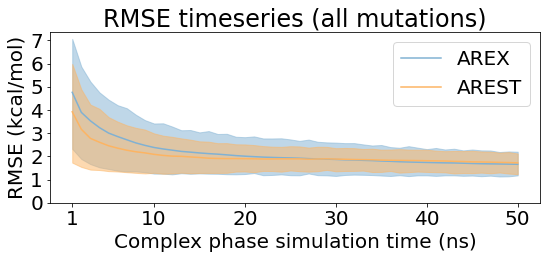

[2.728354569025336, 2.296079001437819, 2.114441125924423, 1.944643213688821, 1.8097270317876553, 1.7403931593966147, 1.6795644278007025, 1.6323827584753026, 1.595992626318251, 1.5560571892184496, 1.5277344549757437, 1.5142089226693556, 1.5053844880734004, 1.4990838305538994, 1.4871468518131221, 1.4804377101405597, 1.4705789226784296, 1.456164703813824, 1.442575524846122, 1.4291371359976353, 1.413994276676967, 1.4028108726132416, 1.3975235773331511, 1.3918510358372522, 1.3866542274083682, 1.3843834551154643, 1.3807558735975753, 1.3765988043765442, 1.3742531223970629, 1.3728727926717312, 1.3680309529624979, 1.3611768951345924, 1.354545696860147, 1.3511200395247553, 1.3418070382675302, 1.3356451818860449, 1.3303186368741813, 1.3260715001310615, 1.3261893705768169, 1.3241686109869986, 1.3209744975528839, 1.3175126269509578, 1.3170870953104745, 1.3121939708888262, 1.3058983366976074, 1.2998134759494775, 1.2967848958636612, 1.294185633297745, 1.2911144493307403, 1.2880506065222768]
[2.290513

<Figure size 432x288 with 0 Axes>

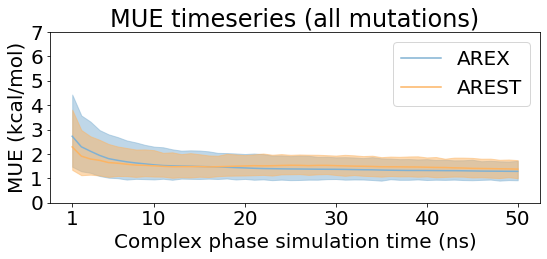

<Figure size 432x288 with 0 Axes>

In [9]:
main_dir_rest = 52
phase = 'complex'

d_mutations = {"Y29F": {"main_dir": 47, 
                      "sub_dir": "0"},
               
               "Y29A": {"main_dir": 47, 
                      "sub_dir": "1"},
               
               "W38F": {"main_dir": 47, 
                      "sub_dir": "2"},
               
               "T42A": {"main_dir": 47, 
                      "sub_dir": "3"},
               
               "E76A": {"main_dir": 47, 
                      "sub_dir": "5"},
               
               "E80A": {"main_dir": 47, 
                      "sub_dir": "6"},
               
               "D35A": {"main_dir": 47, 
                      "sub_dir": "7"},
               
               "D39A": {"main_dir": 47, 
                      "sub_dir": "8"},

               "K27A": {"main_dir": 47, 
                      "sub_dir": "9"},
               
               "R59A": {"main_dir": 47,
                      "sub_dir": "10"},
               
               "R83Q": {"main_dir": 47,
                      "sub_dir": "11"},
               
               "H102A": {"main_dir": 47,
                        "sub_dir": "13"},
               
               "F29Y": {"main_dir": 47,
                         "sub_dir": "14"},
               
               "A29Y": {"main_dir": 47,
                         "sub_dir": "15"},
               
               "F38W": {"main_dir": 47,
                         "sub_dir": "16"},
               
               "F44W": {"main_dir": 47,
                         "sub_dir": "18"},
               
               "A76E": {"main_dir": 47,
                         "sub_dir": "19",
                         "rest_replicate": 1},
               
               "A80E": {"main_dir": 47,
                         "sub_dir": "20"},
               
               "A35D": {"main_dir": 47, 
                      "sub_dir": "21",
                      "rest_replicate": 1},
        
               "A39D": {"main_dir": 47,
                         "sub_dir": "22"},
                
               "A27K": {"main_dir": 47, 
                      "sub_dir": "23"},   
               
               "A59R": {"main_dir": 47,
                         "sub_dir": "24"},
                              
               "Q83R": {"main_dir": 47,
                         "sub_dir": "25"},
               
               "A87R": {"main_dir": 47,
                         "sub_dir": "26"},

               "A102H": {"main_dir": 47,
                         "sub_dir": "27"},

            }

d_labels_to_info = OrderedDict({})
for name, info in d_mutations.items():
    
    main_dir = info["main_dir"]
    sub_dir = info["sub_dir"]
    sub_dir_rest = info["sub_dir"]
    rest_replicate = info["rest_replicate"] if "rest_replicate" in info else 0
    
    base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
    base_path_rest = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_rest}/"

    d_labels_to_info[f"{name} apo (AREX r1)"] = {"file_paths": 
                                                       [os.path.join(base_path, sub_dir, f"replicate_1", f"apo_free_energy_bootstrapped_10ns.pickle")],
                                                  }
    
    d_labels_to_info[ f"{name} complex (AREX r1)"] = {"file_paths": 
                                                           [os.path.join(base_path, sub_dir, "replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                                       "slice_begs": [0],
                                                       "slice_ends": [50],
                                                       "total_iterations": 50000,
                                                      }
    d_labels_to_info[f"{name} complex (AREST r{rest_replicate})"] = {"file_paths": 
                                                                            [os.path.join(base_path_rest, sub_dir_rest, f"replicate_{rest_replicate}", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                                                        "slice_begs": [0],
                                                                        "slice_ends": [50],
                                                                        "total_iterations": 50000,
                                                                      }
# A42T
main_dir = 45
sub_dir = "9"
sub_dir_rest = "17"
phase = 'complex'
base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"

d_labels_to_info["A42T apo (AREX r1)"] = {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"apo_free_energy_bootstrapped_10ns.pickle")],
                                              }
d_labels_to_info["A42T complex (AREX r1)"] = {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [50],
                                               "total_iterations": 50000,
                                              }
d_labels_to_info["A42T complex (AREST r0)"] = {"file_paths": 
                                                    [os.path.join(base_path_rest, sub_dir_rest, "replicate_0", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                                "slice_begs": [0],
                                                "slice_ends": [50],
                                                "total_iterations": 50000,
                                              }

# R87A
main_dir = 45
sub_dir = "10"
sub_dir_rest = "12"
phase = 'complex'
base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"

d_labels_to_info["R87A apo (AREX r1)"] = {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"apo_free_energy_bootstrapped_10ns.pickle")],
                                              }
d_labels_to_info["R87A complex (AREX r1)"] = {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [50],
                                               "total_iterations": 50000,
                                            }
d_labels_to_info["R87A complex (AREST r0)"] = {"file_paths": 
                                                        [os.path.join(base_path_rest, sub_dir_rest, "replicate_0", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                                    "slice_begs": [0],
                                                    "slice_ends": [50],
                                                    "total_iterations": 50000,
                                                  }

# W44F
main_dir = 45
sub_dir = "11"
sub_dir_rest = "4"
phase = 'complex'
base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"

d_labels_to_info["W44F apo (AREX r0)"] = {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_0", f"apo_free_energy_bootstrapped_10ns.pickle")],
                                              }
d_labels_to_info["W44F complex (AREX r0)"] = {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_0", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [50],
                                               "total_iterations": 50000,
                                            }
d_labels_to_info["W44F complex (AREST r0)"] = {"file_paths": 
                                                        [os.path.join(base_path_rest, sub_dir_rest, "replicate_0", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                                    "slice_begs": [0],
                                                    "slice_ends": [50],
                                                    "total_iterations": 50000,
                                                  }

save_path ="/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/"
data_plotter = DataPlotter(d_labels_to_info)
data = data_plotter._generate_free_energy_rmse_mue_timeseries_plot(show_legend=True, y_axis_min=0.0, y_axis_max=8, legend_ncol=1, save_path=save_path)



In [7]:
# note these rmses aren't going to exactly match those in the cinnabar plots 
# because i'm auto-detecting n_equilibration_iterations in cinnabar plots, 
# but here I am discarding first 10% 